In [1]:
import os
import cv2
import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize
import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from geopandas import GeoSeries
from shapely.geometry import Polygon
from rasterio.windows import Window
from rasterio.plot import reshape_as_image


%matplotlib inline

Reading Raster with rasterio

In [85]:
PROJECT_DIR = '/home/ymi/data/ucu_data'

RASTER_PATH = os.path.join(PROJECT_DIR, 'T34JEP_20170101T082332/T34JEP_20170101T082332_TCI.jp2')
TRAIN_POLYGONS_PATH = os.path.join(PROJECT_DIR, 'train-20220726T194123Z-001/train/train.shp')
TEST_POLYGONS_PATH = os.path.join(PROJECT_DIR, 'train-20220726T194123Z-001/test/test.shp')
TRAIN_POLYGONS_CONVERTED = os.path.join(PROJECT_DIR, 'train-20220726T194123Z-001/train/train.geojson')
RASTER_MASK_PATH = os.path.join(PROJECT_DIR, 'mask.jp2')
DROP_CSV_PATH = os.path.join(PROJECT_DIR, 'drop.csv')
FRAGMENT_STORAGE = os.path.join(PROJECT_DIR, 'split')
CROPPED_IMAGES = os.path.join(PROJECT_DIR, 'images_cropped_rgb')

In [62]:
# read converted dataframe with geopandas TRAIN_POLYGONS_CONVERTED


In [63]:
# create tiles of each field

In [64]:
# rasterize works with polygons that are in image coordinate system

def poly_from_utm(polygon, transform):
    poly_pts = []
    
    # make a polygon from multipolygon
    poly = cascaded_union(polygon)
    for i in np.array(poly.exterior.coords):
        
        # transfrom polygon to image crs, using raster meta
        poly_pts.append(~transform * tuple(i))
        
    # make a shapely Polygon object
    new_poly = Polygon(poly_pts)
    return new_poly

In [65]:

# creating binary mask for field/not_filed segmentation.

poly_shp = []

for num, row in train_df.iterrows():
    # check geom type and apply function
    # code here


# rasterize mask mask




SyntaxError: unexpected EOF while parsing (1338464179.py, line 12)

In [67]:
# plotting the mask


In [68]:
# save mask to the disk

In [69]:
# read from disk and plot

In [71]:
def split_image(image_path, save_path, width, height):
    
    img_names = []
    
    if not os.path.exists(save_path):
        os.makedirs(save_path, exist_ok=True)
        print('Data directory created.')

    os.makedirs(f'{save_path}/images', exist_ok=True)
    with rasterio.open(image_path) as src:
        for j in tqdm(range(0, src.height // height)):
            for i in range(0, src.width // width):
                raster_window = src.read(
                    window=Window(i * width, j * height, width, height)
                )
                image_array = reshape_as_image(raster_window)[:, :, :3]
                if np.count_nonzero(image_array) > image_array.size * 0.9:
                    filename_w_ext = os.path.basename(image_path)
                    filename, _ = os.path.splitext(filename_w_ext)
                    image_format = 'png'
                    piece_name = f'{filename}_{j}_{i}.{image_format}'

                    image_array = reshape_as_image(raster_window)
                    img_name = f'{save_path}/images/{piece_name}'
                    img_names.append(img_name)
                    cv2.imwrite(img_name, image_array)

    return img_names

In [73]:
#split mask
def split_mask(image_path, save_path, width, height):
    
    mask_names = []
    drop_list = []
    
    if not os.path.exists(save_path):
        os.makedirs(save_path, exist_ok=True)
        print('Data directory created.')

    os.makedirs(f'{save_path}/masks', exist_ok=True)
    with rasterio.open(image_path) as src:
        for j in tqdm(range(0, src.height // height)):
            for i in range(0, src.width // width):
                raster_window = src.read(window=Window(i * width, j * height, width, height))
                image_array = reshape_as_image(raster_window)
                filename_w_ext = os.path.basename(image_path)
                filename, _ = os.path.splitext(filename_w_ext)
                piece_name = f'{filename}_{j}_{i}.png'

                image_array = reshape_as_image(raster_window)
                # add the code here to subsample 10% of images for train and add it to drop_list

                mask_name = f'{save_path}/masks/{piece_name}'
                mask_names.append(mask_name)
                image_array[image_array>1] = 1
                cv2.imwrite(mask_name, image_array)

    return mask_names, drop_list

In [46]:
image_names = split_image(RASTER_PATH, FRAGMENT_STORAGE, 256, 256)

100%|███████████████████████████████████████████| 42/42 [01:03<00:00,  1.52s/it]


In [47]:
mask_names, drop_list = split_mask(RASTER_MASK_PATH, FRAGMENT_STORAGE, 256, 256)

100%|███████████████████████████████████████████| 42/42 [00:04<00:00,  9.97it/s]


In [86]:
drop_list_df = pd.DataFrame()
drop_list_df['images_to_drop'] = drop_list
drop_list_df.to_csv(DROP_CSV_PATH, index=False)

In [88]:
train_df

,Field_Id,Area,Subregion,Crop_Id_Ne,geometry
0,1,0.915905,3,8,"POLYGON ((613924.332 6793991.295, 614051.496 6..."
1,2,2.064410,3,6,"POLYGON ((614404.072 6794020.580, 614332.996 6..."
2,3,1.080300,3,8,"POLYGON ((614320.215 6793964.242, 614322.608 6..."
3,4,1.316190,3,8,"POLYGON ((614560.533 6794002.249, 614551.324 6..."
4,7,5.529220,3,8,"POLYGON ((614596.656 6794269.865, 614460.168 6..."
...,...,...,...,...,...
3563,3595,4.026750,6,None,"POLYGON ((544494.639 6857712.780, 544627.994 6..."
3564,3601,3.291510,7,None,"POLYGON ((541538.301 6854638.691, 541373.855 6..."
3565,3604,0.202729,3,None,"POLYGON ((614032.751 6794304.593, 614037.787 6..."
3566,3605,0.252428,3,None,"POLYGON ((613963.294 6794488.531, 614007.440 6..."


In [74]:
# create by removing masks 
used_image_names = 
used_masks = [mask_names[i] for i in range(0, len(mask_names)) if mask_names[i] not in drop_list]

SyntaxError: invalid syntax (820192708.py, line 2)

In [87]:
used_image_names

['/home/ymi/data/ucu_data/split/images/T34JEP_20170101T082332_TCI_0_14.png',
 '/home/ymi/data/ucu_data/split/images/T34JEP_20170101T082332_TCI_0_26.png',
 '/home/ymi/data/ucu_data/split/images/T34JEP_20170101T082332_TCI_0_27.png',
 '/home/ymi/data/ucu_data/split/images/T34JEP_20170101T082332_TCI_0_39.png',
 '/home/ymi/data/ucu_data/split/images/T34JEP_20170101T082332_TCI_0_40.png',
 '/home/ymi/data/ucu_data/split/images/T34JEP_20170101T082332_TCI_1_22.png',
 '/home/ymi/data/ucu_data/split/images/T34JEP_20170101T082332_TCI_1_29.png',
 '/home/ymi/data/ucu_data/split/images/T34JEP_20170101T082332_TCI_1_39.png',
 '/home/ymi/data/ucu_data/split/images/T34JEP_20170101T082332_TCI_2_5.png',
 '/home/ymi/data/ucu_data/split/images/T34JEP_20170101T082332_TCI_2_10.png',
 '/home/ymi/data/ucu_data/split/images/T34JEP_20170101T082332_TCI_2_14.png',
 '/home/ymi/data/ucu_data/split/images/T34JEP_20170101T082332_TCI_2_17.png',
 '/home/ymi/data/ucu_data/split/images/T34JEP_20170101T082332_TCI_2_24.png',


In [79]:
len(used_image_names)

242

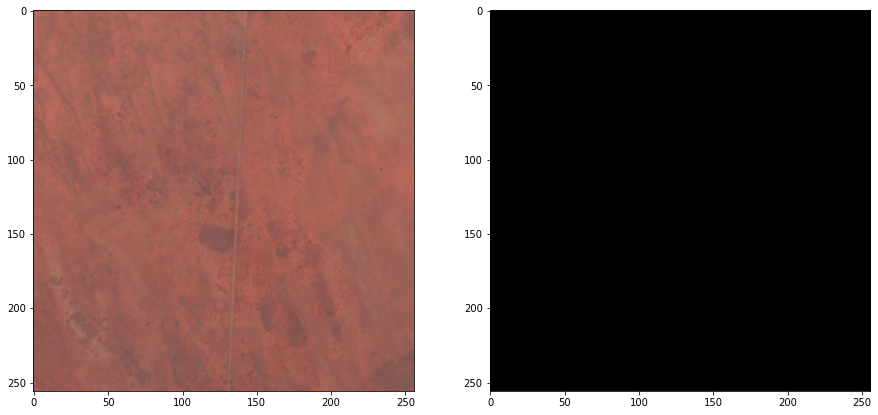

In [78]:
# read and plot tile

f, axarr = plt.subplots(1, 2)
f.set_size_inches(15, 15)
axarr[0].imshow(raster_image)
axarr[1].imshow(mask_image, 'gray')